In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pycaret.regression 
import pycaret.clustering 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
from helper_functions import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

# 0. Data import

We will use the NY Stock Exchange data for training, and the Berlin data for testing. That way we will ensure that the model is useful to be extrapolated to different indexes and stocks. 

In [2]:
data_NY = import_index_data(symbol="NYA")
data_DE = import_index_data(symbol="GDAXI")

In [3]:
data_NY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13948 entries, 0 to 13947
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    13948 non-null  datetime64[ns]
 1   Close   13948 non-null  float64       
 2   Volume  13948 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 327.0 KB


In [4]:
data_train = create_modeling_df(data_NY, 400, snippet_size=20, projection_step=30, scaling ="minmax")
data_test = create_modeling_df(data_DE, 100, snippet_size=20, projection_step=30, scaling ="minmax")

In [5]:
X_train = data_train.drop(columns=["Pivot_date", "Target_value"])
X_test = data_test.drop(columns=["Pivot_date", "Target_value"])
y_train = data_train["Target_value"]
y_test = data_test["Target_value"]

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 41) (100, 41) (400,) (100,)


# 1. Trends clustering model

First we have to drop the final value (pivot value) so the clustering model receives only the normalized trend data.

In [7]:
X_cluster_train = X_train.drop(columns=["Pivot_value"])
X_cluster_test = X_test.drop(columns=["Pivot_value"])

We will use custom functions to calculate an elbow and silhouette graph:

Trained a K-Means model with 2 neighbours! Time needed = 0.036 seconds.
Trained a K-Means model with 4 neighbours! Time needed = 0.049 seconds.
Trained a K-Means model with 6 neighbours! Time needed = 0.049 seconds.
Trained a K-Means model with 8 neighbours! Time needed = 0.051 seconds.
Trained a K-Means model with 10 neighbours! Time needed = 0.056 seconds.
Trained a K-Means model with 12 neighbours! Time needed = 0.064 seconds.
Trained a K-Means model with 14 neighbours! Time needed = 0.056 seconds.
Trained a K-Means model with 16 neighbours! Time needed = 0.084 seconds.
Trained a K-Means model with 18 neighbours! Time needed = 0.073 seconds.
Trained a K-Means model with 20 neighbours! Time needed = 0.075 seconds.
Trained a K-Means model with 22 neighbours! Time needed = 0.084 seconds.
Trained a K-Means model with 24 neighbours! Time needed = 0.083 seconds.
Trained a K-Means model with 26 neighbours! Time needed = 0.094 seconds.
Trained a K-Means model with 28 neighbours! Time needed

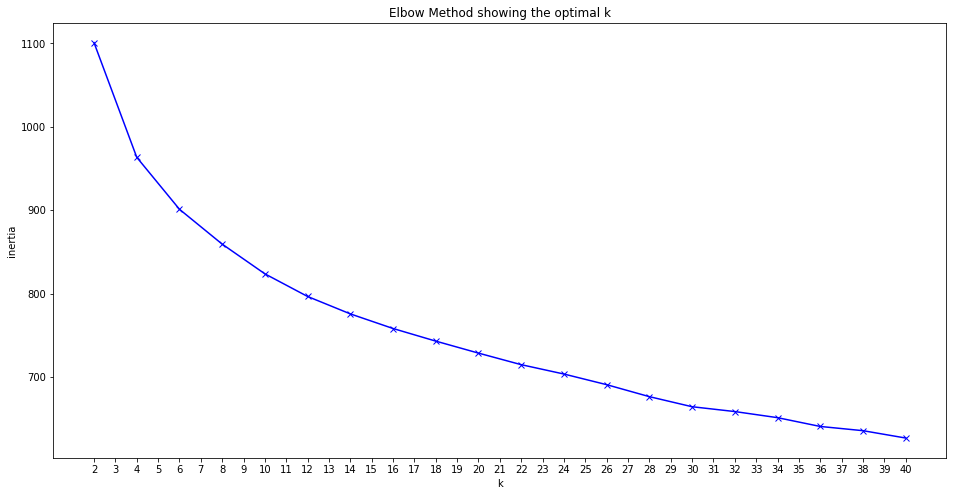

0

In [8]:
elbow_graph(X_cluster_train)

Calculated silhouette with 2 neighbours! Time needed = 0.038 seconds.
Calculated silhouette with 4 neighbours! Time needed = 0.056 seconds.
Calculated silhouette with 6 neighbours! Time needed = 0.052 seconds.
Calculated silhouette with 8 neighbours! Time needed = 0.052 seconds.
Calculated silhouette with 10 neighbours! Time needed = 0.066 seconds.
Calculated silhouette with 12 neighbours! Time needed = 0.061 seconds.
Calculated silhouette with 14 neighbours! Time needed = 0.061 seconds.
Calculated silhouette with 16 neighbours! Time needed = 0.078 seconds.
Calculated silhouette with 18 neighbours! Time needed = 0.080 seconds.
Calculated silhouette with 20 neighbours! Time needed = 0.081 seconds.
Calculated silhouette with 22 neighbours! Time needed = 0.089 seconds.
Calculated silhouette with 24 neighbours! Time needed = 0.095 seconds.
Calculated silhouette with 26 neighbours! Time needed = 0.103 seconds.
Calculated silhouette with 28 neighbours! Time needed = 0.102 seconds.
Calculated

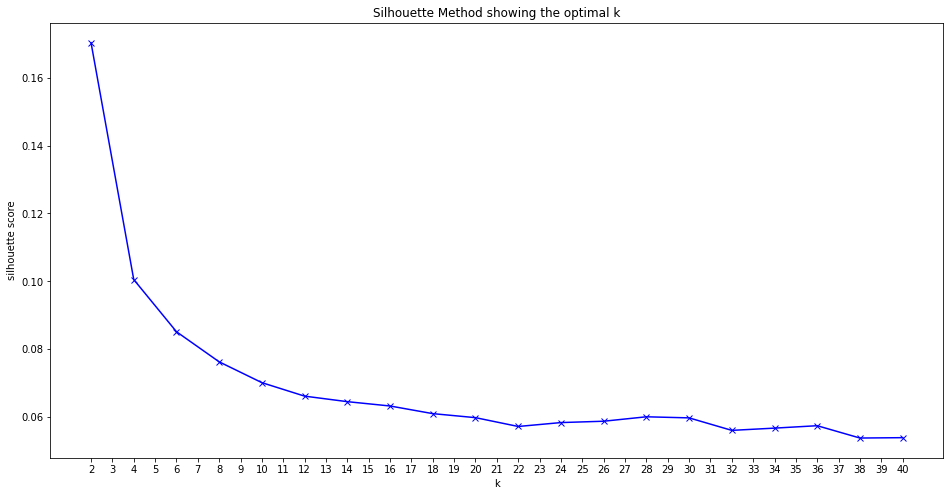

In [9]:
silhouette_graph(X_cluster_train)

We will create 15 clusters, one for each main trend. Next, we will train a model with our training data and visualise the trends that the clustering is trying to capture.

In [10]:
clustering_model = KMeans(init="k-means++", n_clusters=15)

In [11]:
#We fit the Kmeans to the training data
clustering_model.fit(X_cluster_train)

#We create the arrays with the predicted clusters, for the training and test data
clusters_train = clustering_model.predict(X_cluster_train)
clusters_test = clustering_model.predict(X_cluster_test)

#We incorporate the clusters to the training and test dataframes, and cast them to objects
X_train["Cluster"] = clusters_train
X_test["Cluster"] = clusters_test
X_train["Cluster"]= X_train["Cluster"].astype(object)
X_test["Cluster"]= X_test["Cluster"].astype(object)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vol0         400 non-null    float64
 1   Vol1         400 non-null    float64
 2   Vol2         400 non-null    float64
 3   Vol3         400 non-null    float64
 4   Vol4         400 non-null    float64
 5   Vol5         400 non-null    float64
 6   Vol6         400 non-null    float64
 7   Vol7         400 non-null    float64
 8   Vol8         400 non-null    float64
 9   Vol9         400 non-null    float64
 10  Vol10        400 non-null    float64
 11  Vol11        400 non-null    float64
 12  Vol12        400 non-null    float64
 13  Vol13        400 non-null    float64
 14  Vol14        400 non-null    float64
 15  Vol15        400 non-null    float64
 16  Vol16        400 non-null    float64
 17  Vol17        400 non-null    float64
 18  Vol18        400 non-null    float64
 19  Vol19   

Now we try to visualise what the clustering model does:
1. With a PCA decomposition
2. Visualising some trends for each cluster, and see if they seem related.

In [ ]:
#visualise_model(X_train, init_algo="k-means++", n_clusters=15, n_init=4)

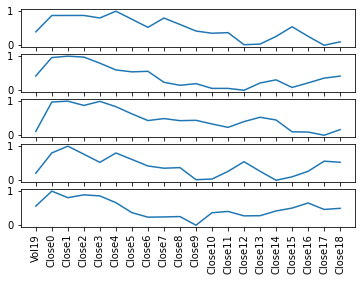

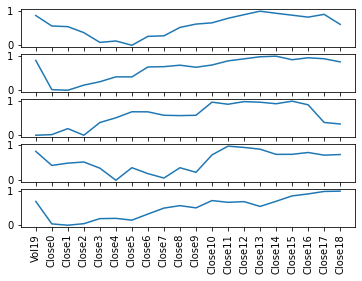

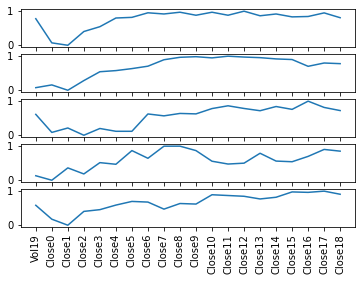

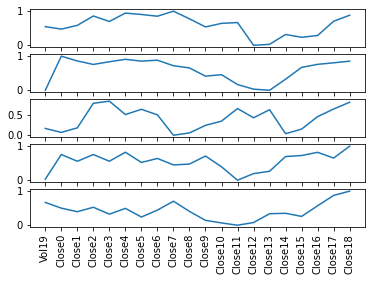

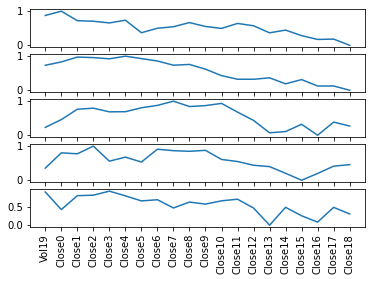

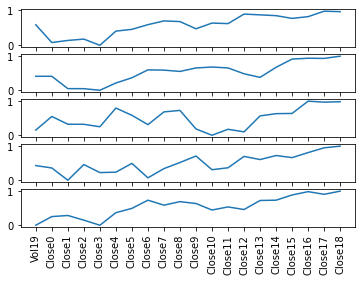

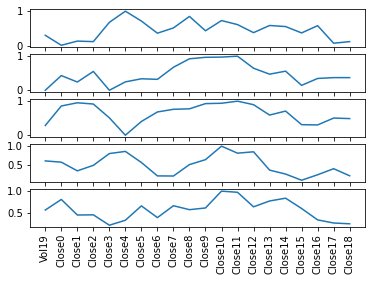

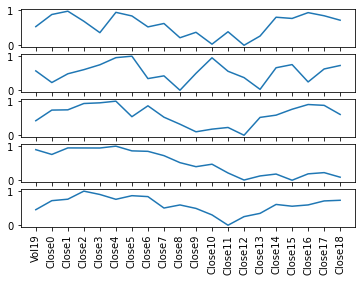

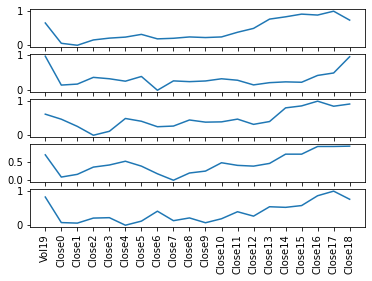

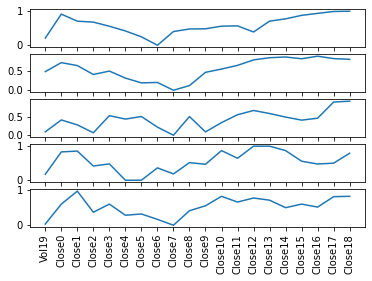

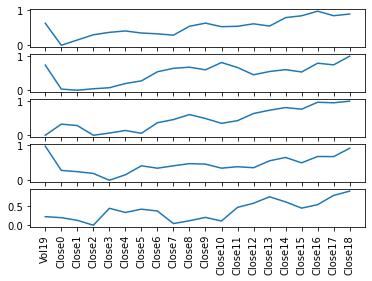

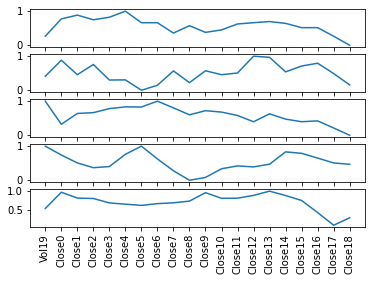

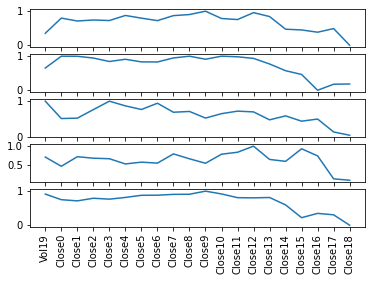

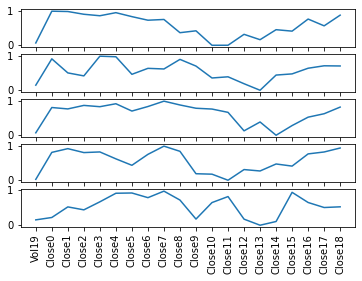

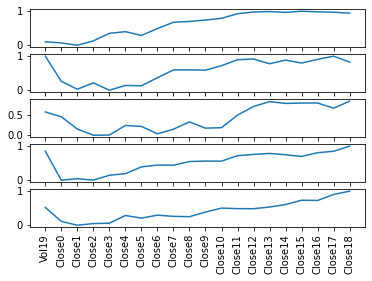

In [13]:
visualise_clusters(X_train, n_per_cluster=5)

# 2. Regression model using clustering results

Now we will use a tool called Pycaret to study which regression models are more useful. We will have several scenarios:
1. Passing all the information, including price, volumes and clusters, as well as pivot value, to the model.
2. Only passing the calculated clusters, together with the pivot value.
3. Passing the volume information, the calculated clusters, and the pivot value.

## 2.1 All the information

In [15]:
regression_data_1 = X_train.copy()
regression_data_1["Target_value"] = y_train

In [16]:
regression_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vol0          400 non-null    float64
 1   Vol1          400 non-null    float64
 2   Vol2          400 non-null    float64
 3   Vol3          400 non-null    float64
 4   Vol4          400 non-null    float64
 5   Vol5          400 non-null    float64
 6   Vol6          400 non-null    float64
 7   Vol7          400 non-null    float64
 8   Vol8          400 non-null    float64
 9   Vol9          400 non-null    float64
 10  Vol10         400 non-null    float64
 11  Vol11         400 non-null    float64
 12  Vol12         400 non-null    float64
 13  Vol13         400 non-null    float64
 14  Vol14         400 non-null    float64
 15  Vol15         400 non-null    float64
 16  Vol16         400 non-null    float64
 17  Vol17         400 non-null    float64
 18  Vol18         400 non-null    

In [17]:
reg1 = pycaret.regression.setup(regression_data_1, target = "Target_value", 
                                remove_perfect_collinearity=False) #log_experiment=True, experiment_name='first_trial')

,Description,Value
0,session_id,1863
1,Target,Target_value
2,Original Data,"(400, 43)"
3,Missing Values,False
4,Numeric Features,41
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(279, 56)"


In [18]:
best = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,358.0375,280954.4774,511.3655,0.9536,0.0615,0.0435,0.0060
en,Elastic Net,359.8200,282767.8188,513.5520,0.9531,0.0620,0.0438,0.0070
huber,Huber Regressor,362.6573,291385.8028,522.9187,0.9513,0.0641,0.0446,0.0070
gbr,Gradient Boosting Regressor,373.7062,304388.6392,532.0450,0.9511,0.0630,0.0450,0.0460
et,Extra Trees Regressor,362.4944,299288.5141,530.6537,0.9503,0.0652,0.0443,0.1630
llar,Lasso Least Angle Regression,381.3110,308775.9191,541.5161,0.9487,0.0670,0.0470,0.0060
omp,Orthogonal Matching Pursuit,388.9647,315952.0383,545.9471,0.9473,0.0672,0.0476,0.0110
rf,Random Forest Regressor,391.1261,314736.2870,541.6106,0.9470,0.0658,0.0478,0.1780
knn,K Neighbors Regressor,400.3102,318634.6227,546.4348,0.9458,0.0665,0.0489,0.0260
ridge,Ridge Regression,407.8396,337232.0641,569.6146,0.9442,0.0720,0.0510,0.0050


In [51]:
help(reg1)

Help on RegressionExperiment in module pycaret.internal.pycaret_experiment.regression_experiment object:

class RegressionExperiment(pycaret.internal.pycaret_experiment.supervised_experiment._SupervisedExperiment)
 |  RegressionExperiment() -> None
 |  
 |  Method resolution order:
 |      RegressionExperiment
 |      pycaret.internal.pycaret_experiment.supervised_experiment._SupervisedExperiment
 |      pycaret.internal.pycaret_experiment.tabular_experiment._TabularExperiment
 |      pycaret.internal.pycaret_experiment.pycaret_experiment._PyCaretExperiment
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_metric(self, id: str, name: str, score_func: type, greater_is_better: bool = True, **kwargs) -> pandas.core.series.Series
 |      Adds a custom metric to be used for CV.
 |      
 |      
 |      Example
 |      -------
 |      >>> from pycaret.datasets import get_

Let's analyse the model's results:

In [46]:
model = pycaret.regression.create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,550.5540,757324.8214,870.2441,0.9108,0.0798,0.0565
1,316.4890,248507.6081,498.5054,0.9639,0.0474,0.0333
2,257.4385,130012.8452,360.5729,0.9795,0.0413,0.0310
3,371.6370,229890.1497,479.4686,0.9689,0.0657,0.0438
4,308.9679,165623.8815,406.9691,0.9675,0.0508,0.0383
5,397.4020,299778.9714,547.5207,0.9666,0.0783,0.0543
6,369.0059,393198.9528,627.0558,0.8886,0.0903,0.0535
7,336.0723,212133.5551,460.5796,0.9531,0.0550,0.0420
8,342.8153,168087.4620,409.9847,0.9717,0.0467,0.0378
9,329.9931,204986.5272,452.7544,0.9657,0.0604,0.0447


In [49]:
pycaret.regression.evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Now we will use the model to predict the values for the DAX stock information:

In [52]:
y_test_predict = pycaret.regression.predict_model(model, X_test)

In [56]:
y_test_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 43 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vol0         100 non-null    float64
 1   Vol1         100 non-null    float64
 2   Vol2         100 non-null    float64
 3   Vol3         100 non-null    float64
 4   Vol4         100 non-null    float64
 5   Vol5         100 non-null    float64
 6   Vol6         100 non-null    float64
 7   Vol7         100 non-null    float64
 8   Vol8         100 non-null    float64
 9   Vol9         100 non-null    float64
 10  Vol10        100 non-null    float64
 11  Vol11        100 non-null    float64
 12  Vol12        100 non-null    float64
 13  Vol13        100 non-null    float64
 14  Vol14        100 non-null    float64
 15  Vol15        100 non-null    float64
 16  Vol16        100 non-null    float64
 17  Vol17        100 non-null    float64
 18  Vol18        100 non-null    float64
 19  Vol19    

In [57]:
r2_score(y_test, y_test_predict["Label"])

0.9746291972364833

In [45]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vol0         100 non-null    float64
 1   Vol1         100 non-null    float64
 2   Vol2         100 non-null    float64
 3   Vol3         100 non-null    float64
 4   Vol4         100 non-null    float64
 5   Vol5         100 non-null    float64
 6   Vol6         100 non-null    float64
 7   Vol7         100 non-null    float64
 8   Vol8         100 non-null    float64
 9   Vol9         100 non-null    float64
 10  Vol10        100 non-null    float64
 11  Vol11        100 non-null    float64
 12  Vol12        100 non-null    float64
 13  Vol13        100 non-null    float64
 14  Vol14        100 non-null    float64
 15  Vol15        100 non-null    float64
 16  Vol16        100 non-null    float64
 17  Vol17        100 non-null    float64
 18  Vol18        100 non-null    float64
 19  Vol19    

In [42]:
encoder = preprocessing.OneHotEncoder()

In [44]:
encoder.fit(X_test["Cluster"].reshape(1,-1))

AttributeError: 'Series' object has no attribute 'reshape'

In [38]:
X_test_transformed = encoder.transform(X_test)

In [40]:
X_test_transformed

<100x3753 sparse matrix of type '<class 'numpy.float64'>'
	with 4200 stored elements in Compressed Sparse Row format>

In [41]:
best.predict(X_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 56 is different from 42)

In [20]:
def evaluate(model, X_test, y_test, silent=False):
    """
    Input: a regressor, the matrix with test features, the vector with test labels.
    Output: a list with the accuracy, the R2 coefficient of determination, and the average error (absolute)
    """
    
    y_predict = model.predict(X_test)
    errors = abs(y_predict - y_test)
    mape = 100 * np.mean(errors / y_test)
    avg_error = np.mean(errors)
    accuracy = 100 - mape
    r2 = r2_score(y_test, y_predict)
    if not silent:
        print('---Model Performance---')
        print(model)
        #print(X_test.columns)
        print('\nAverage Absolute Error: {:0.1f} dollars.'.format(np.mean(errors)))
        print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict, squared=False))
        print('Accuracy = {:0.2f}%.'.format(accuracy))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.2f\n' % r2)
    
    return [accuracy, r2, avg_error]

In [21]:
evaluate(best, X_test, y_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 56 is different from 42)